Action1	"PM2.5数据集
https://archive.ics.uci.edu/ml/datasets/Beijing%20PM2.5%20Data
预测未来北京PM2.5的值"			

1、使用时间序列工具（ARMA或者LTSM）（40points）
2、结果正确（20points）
3、代码进行注释，写明解决方案思路（20points)

PM2.5的分级标准为：
优 35微克（ug）/每立方
良 35~75微克（ug）/每立方
轻度污染 75~115微克（ug）/每立方
中度污染 115~150微克（ug）/每立方
重度污染 150~250微克（ug）/每立方
严重污染 250及以上微克（ug）/每立方

In [11]:
# 使用LSTM对PM2.5进行预测，根据8个特征维度预测PM指数 pollution
import pandas as pd
from pandas import read_csv, DataFrame, concat
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from itertools import chain
from datetime import datetime

In [8]:
# 将时间序列数据转换为适用于监督学习的数据
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # 预测序列 (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    agg = concat(cols, axis=1)
    agg.columns = names
    # 去掉NaN行
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [9]:
# 数据加载
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')

In [12]:
dataset = read_csv('./raw.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset

,No,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
year_month_day_hour,,,,,,,,,
2010-01-01 00:00:00,1,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,2,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,3,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,4,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,5,NaN,-20,-12.0,1018.0,NW,12.97,0,0
...,...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,43820,8.0,-23,-2.0,1034.0,NW,231.97,0,0
2014-12-31 20:00:00,43821,10.0,-22,-3.0,1034.0,NW,237.78,0,0
2014-12-31 21:00:00,43822,10.0,-22,-3.0,1034.0,NW,242.70,0,0


In [13]:
dataset.drop('No', axis=1, inplace=True)

In [14]:
dataset

,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
year_month_day_hour,,,,,,,,
2010-01-01 00:00:00,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,NaN,-20,-12.0,1018.0,NW,12.97,0,0
...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,8.0,-23,-2.0,1034.0,NW,231.97,0,0
2014-12-31 20:00:00,10.0,-22,-3.0,1034.0,NW,237.78,0,0
2014-12-31 21:00:00,10.0,-22,-3.0,1034.0,NW,242.70,0,0


In [15]:
#列名替换
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
year_month_day_hour,,,,,,,,
2010-01-01 00:00:00,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,NaN,-20,-12.0,1018.0,NW,12.97,0,0
...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,8.0,-23,-2.0,1034.0,NW,231.97,0,0
2014-12-31 20:00:00,10.0,-22,-3.0,1034.0,NW,237.78,0,0
2014-12-31 21:00:00,10.0,-22,-3.0,1034.0,NW,242.70,0,0


In [16]:
dataset.index.name = 'date'

In [17]:
dataset

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-01 00:00:00,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,NaN,-20,-12.0,1018.0,NW,12.97,0,0
...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,8.0,-23,-2.0,1034.0,NW,231.97,0,0
2014-12-31 20:00:00,10.0,-22,-3.0,1034.0,NW,237.78,0,0
2014-12-31 21:00:00,10.0,-22,-3.0,1034.0,NW,242.70,0,0


In [18]:
#缺失值填充
dataset['pollution'].fillna(0, inplace=True)      
dataset

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-01 00:00:00,0.0,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,0.0,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,0.0,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,0.0,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,0.0,-20,-12.0,1018.0,NW,12.97,0,0
...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,8.0,-23,-2.0,1034.0,NW,231.97,0,0
2014-12-31 20:00:00,10.0,-22,-3.0,1034.0,NW,237.78,0,0
2014-12-31 21:00:00,10.0,-22,-3.0,1034.0,NW,242.70,0,0


In [19]:
#去掉第一天数据
dataset = dataset[24:]

In [20]:
dataset

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0
...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,8.0,-23,-2.0,1034.0,NW,231.97,0,0
2014-12-31 20:00:00,10.0,-22,-3.0,1034.0,NW,237.78,0,0
2014-12-31 21:00:00,10.0,-22,-3.0,1034.0,NW,242.70,0,0


In [21]:
#保存数据
dataset.to_csv('m_pollution.csv')

In [22]:
#可视化分析
dataset = pd.read_csv("./m_pollution.csv", index_col=0)
dataset

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0
...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,8.0,-23,-2.0,1034.0,NW,231.97,0,0
2014-12-31 20:00:00,10.0,-22,-3.0,1034.0,NW,237.78,0,0
2014-12-31 21:00:00,10.0,-22,-3.0,1034.0,NW,242.70,0,0


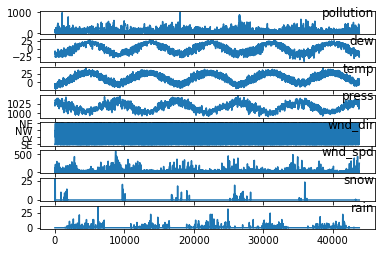

In [23]:
# 设置需要可视化的列表
groups = [0, 1, 2, 3, 4, 5, 6, 7]
i = 1
# 数据探索EDA
#plt.figure()
for group in range(8):
	plt.subplot(8, 1, i)
	plt.plot(values[:, group])
	plt.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
plt.show()

In [24]:
# 将分类特征wnd_dir 进行标签编码
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# 设置数据类型均为flast32
values = values.astype('float32')
#pd.DataFrame(values).to_csv('values.csv')
print(values)

[[129.   -16.    -4.   ...   1.79   0.     0.  ]
 [148.   -15.    -4.   ...   2.68   0.     0.  ]
 [159.   -11.    -5.   ...   3.57   0.     0.  ]
 ...
 [ 10.   -22.    -3.   ... 242.7    0.     0.  ]
 [  8.   -22.    -4.   ... 246.72   0.     0.  ]
 [ 12.   -21.    -3.   ... 249.85   0.     0.  ]]


In [25]:
# 数据归一化,对所有数据进行0-1规范化
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
print(scaled.shape)

(43800, 8)


In [26]:
# 将时间序列数据转换为适合监督学习的数据
reframed = series_to_supervised(scaled, 1, 1)
print(reframed)
reframed.to_csv('reframed-1.csv')

       var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1       0.129779   0.352941   0.245902   0.527273   0.666667   0.002290   
2       0.148893   0.367647   0.245902   0.527273   0.666667   0.003811   
3       0.159960   0.426471   0.229508   0.545454   0.666667   0.005332   
4       0.182093   0.485294   0.229508   0.563637   0.666667   0.008391   
5       0.138833   0.485294   0.229508   0.563637   0.666667   0.009912   
...          ...        ...        ...        ...        ...        ...   
43795   0.010060   0.264706   0.278689   0.763638   0.333333   0.385730   
43796   0.008048   0.250000   0.278689   0.781818   0.333333   0.395659   
43797   0.010060   0.264706   0.262295   0.781818   0.333333   0.405588   
43798   0.010060   0.264706   0.262295   0.781818   0.333333   0.413996   
43799   0.008048   0.264706   0.245902   0.781818   0.333333   0.420866   

       var7(t-1)  var8(t-1)   var1(t)   var2(t)   var3(t)   var4(t)   var5(t)  \
1       0.000000  

In [29]:
# 去掉不需要预测的列，即var2(t)	var3(t)	var4(t)	var5(t)	var6(t)	var7(t)	var8(t)
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
reframed.to_csv('reframed-2.csv')
#print(reframed.head())

IndexError: index 9 is out of bounds for axis 0 with size 9

In [30]:
# 训练集80%，测试集20%
values = reframed.values
n_train_hours = int(len(values) * 0.8)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

In [31]:
# :-1表示从0到数组最后一位，-1表示数组最后一位
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
print(train_X.shape)

(35039, 8)


In [33]:
#转换为LSTM需要的数据格式,转换成3D格式 [样本数, 时间步, 特征数]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
#print(train_X)
#print(test_X)

ValueError: cannot reshape array of size 280312 into shape (35039,1,1)

In [34]:
#模型搭建
model = Sequential()
print('shape = ', train_X.shape)
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2]))) # 1,8, train_X.shape = (35039, 1, 8)
print(test_X.shape[2])
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# 模型训练, verbose = 2 为每个epoch输出一行记录, =1为输出进度条记录, =0 不在标准输出流输出日志信息
result = model.fit(train_X, train_y, epochs=10, batch_size=32, validation_data=(test_X, test_y), verbose=2, shuffle=False)

shape =  (35039, 1, 8)
8
Epoch 1/10
1095/1095 - 4s - loss: 0.0021 - val_loss: 0.0026
Epoch 2/10
1095/1095 - 3s - loss: 8.0862e-04 - val_loss: 0.0013
Epoch 3/10
1095/1095 - 3s - loss: 8.0702e-04 - val_loss: 0.0012
Epoch 4/10
1095/1095 - 3s - loss: 8.1073e-04 - val_loss: 0.0012
Epoch 5/10
1095/1095 - 3s - loss: 8.0951e-04 - val_loss: 0.0012
Epoch 6/10
1095/1095 - 3s - loss: 8.0739e-04 - val_loss: 0.0012
Epoch 7/10
1095/1095 - 3s - loss: 8.0517e-04 - val_loss: 0.0011
Epoch 8/10
1095/1095 - 3s - loss: 8.0304e-04 - val_loss: 0.0011
Epoch 9/10
1095/1095 - 3s - loss: 8.0107e-04 - val_loss: 0.0011
Epoch 10/10
1095/1095 - 3s - loss: 7.9928e-04 - val_loss: 0.0011


In [35]:
# 模型预测
train_predict = model.predict(train_X)
test_predict = model.predict(test_X)

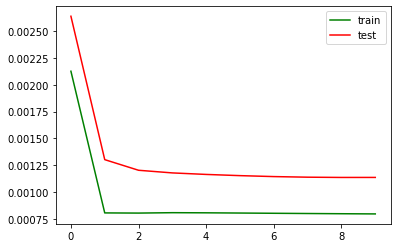

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                11800     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 11,851
Trainable params: 11,851
Non-trainable params: 0
_________________________________________________________________
None


In [36]:
# 绘制训练损失和测试损失
line1 = result.history['loss']
line2 = result.history['val_loss']
plt.plot(line1, label='train', c='g')
plt.plot(line2, label='test', c='r')
plt.legend(loc='best')
plt.show()
print(model.summary())

In [37]:
# 呈现原始数据，训练结果，预测结果
def plot_img(source_data_set, train_predict, test_predict):
    # 原始数据蓝色
    plt.plot(source_data_set[:, -1], label='real', c='b')
    # 训练数据绿色
    plt.plot([x for x in train_predict], label='train predict', c='g')
    # 预测结果红色
    plt.plot([None for _ in train_predict] + [x for x in test_predict], label='test predict', c='r')
    plt.legend()
    plt.show()

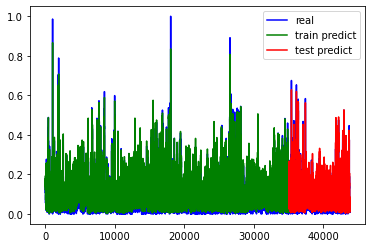

In [38]:
# 绘制预测结果与实际结果对比
plot_img(values, train_predict, test_predict)

In [39]:
#采用ARIMA模型
from itertools import product
import statsmodels.api as sm

In [40]:
# 设置参数范围
ps = range(0, 5)
qs = range(0, 5)
ds = range(1, 5)

In [41]:
parameters = product(ps, ds, qs)
parameters_list = list(parameters)

In [42]:
parameters_list[:5]

[(0, 1, 0), (0, 1, 1), (0, 1, 2), (0, 1, 3), (0, 1, 4)]

In [43]:
## 寻找最优ARMA模型参数，即best_aic最小
results = []
best_aic = float("inf") # 正无穷

In [ ]:
%%time
for param in parameters_list:
    try:
        model = sm.tsa.statespace.SARIMAX(train_y,
                                order=(param[0], param[1], param[2]),
                                enforce_stationarity=False,
                                enforce_invertibility=False).fit()
    except ValueError:
        print('参数错误:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    print("参数: ", param, "训练完成")

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


参数:  (0, 1, 0) 训练完成
参数:  (0, 1, 1) 训练完成
参数:  (0, 1, 2) 训练完成
参数:  (0, 1, 3) 训练完成


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


参数:  (0, 1, 4) 训练完成
参数:  (0, 2, 0) 训练完成
参数:  (0, 2, 1) 训练完成
参数:  (0, 2, 2) 训练完成
参数:  (0, 2, 3) 训练完成
参数:  (0, 2, 4) 训练完成


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


参数:  (0, 3, 0) 训练完成
参数:  (0, 3, 1) 训练完成
参数:  (0, 3, 2) 训练完成
参数:  (0, 3, 3) 训练完成
参数:  (0, 3, 4) 训练完成
参数:  (0, 4, 0) 训练完成
参数:  (0, 4, 1) 训练完成
参数:  (0, 4, 2) 训练完成
参数:  (0, 4, 3) 训练完成
参数:  (0, 4, 4) 训练完成
参数:  (1, 1, 0) 训练完成


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


参数:  (1, 1, 1) 训练完成
参数:  (1, 1, 2) 训练完成
参数:  (1, 1, 3) 训练完成
参数:  (1, 1, 4) 训练完成


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


参数:  (1, 2, 0) 训练完成
参数:  (1, 2, 1) 训练完成
参数:  (1, 2, 2) 训练完成
参数:  (1, 2, 3) 训练完成
参数:  (1, 2, 4) 训练完成


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


参数:  (1, 3, 0) 训练完成
参数:  (1, 3, 1) 训练完成
参数:  (1, 3, 2) 训练完成
参数:  (1, 3, 3) 训练完成
参数:  (1, 3, 4) 训练完成


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


参数:  (1, 4, 0) 训练完成
参数:  (1, 4, 1) 训练完成


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


参数:  (1, 4, 2) 训练完成
参数:  (1, 4, 3) 训练完成
参数:  (1, 4, 4) 训练完成
参数:  (2, 1, 0) 训练完成
参数:  (2, 1, 1) 训练完成
参数:  (2, 1, 2) 训练完成
参数:  (2, 1, 3) 训练完成


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


参数:  (2, 1, 4) 训练完成
参数:  (2, 2, 0) 训练完成
参数:  (2, 2, 1) 训练完成
参数:  (2, 2, 2) 训练完成


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


参数:  (2, 2, 3) 训练完成
参数:  (2, 2, 4) 训练完成
参数:  (2, 3, 0) 训练完成
参数:  (2, 3, 1) 训练完成
参数:  (2, 3, 2) 训练完成
参数:  (2, 3, 3) 训练完成


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


参数:  (2, 3, 4) 训练完成
参数:  (2, 4, 0) 训练完成
参数:  (2, 4, 1) 训练完成


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


参数:  (2, 4, 2) 训练完成
参数:  (2, 4, 3) 训练完成


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


参数:  (2, 4, 4) 训练完成
参数:  (3, 1, 0) 训练完成
参数:  (3, 1, 1) 训练完成


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


参数:  (3, 1, 2) 训练完成
参数:  (3, 1, 3) 训练完成


In [ ]:
print('最优模型: ', best_model.summary())

In [ ]:
#预测
predict_y = best_model.get_prediction(start=0, end=len(train_y)+len(test_y)).predicted_mean

In [ ]:
train_predict = predict_y[: len(train_y)]

In [ ]:
test_predict = predict_y[len(train_y):]

In [ ]:
plt.plot(values[:, -1], label="real", c="b")
# 训练集预测结果绿色
plt.plot(list(train_predict), label="train_predict", c="g")
#  测试集预测结果红色
plt.plot([None for _ in train_predict] + list(test_predict), label="test_predict", c="r")
plt.legend(loc="best")
plt.show()

#LSTM效果比ARIMA好